# Basic data access functions of the pyphenocam package

In [1]:
import datetime as dt

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

import skimage
from skimage import data, img_as_float

In [2]:
import sys
sys.path.append(r"..")
import pyphenocam

sys.path.append(r"J:\Projects\NCCSC\phenocam\Tools\DaymetPy\daymetpy")
import daymetpy

In [3]:
sites = pyphenocam.dataaccess.get_sites_df()
sites.head(4)

site        lat         lon  elevation  \
0          acadia  44.376944  -68.260833      158.0   
1   aguatibiaeast  33.622000 -116.867000     1086.0   
2  aguatibianorth  33.602220 -117.343680     1090.0   
3        ahwahnee  37.746700 -119.581600     1199.0   

                                         description  
0   McFarland Hill, Acadia National Park, Maine, USA  
1             Agua Tibia Wilderness, California, USA  
2             Agua Tibia Wilderness, California, USA  
3  Half Dome, Yosemite National Park, California,...

### If we have cartopy installed we can take a look at these on a map

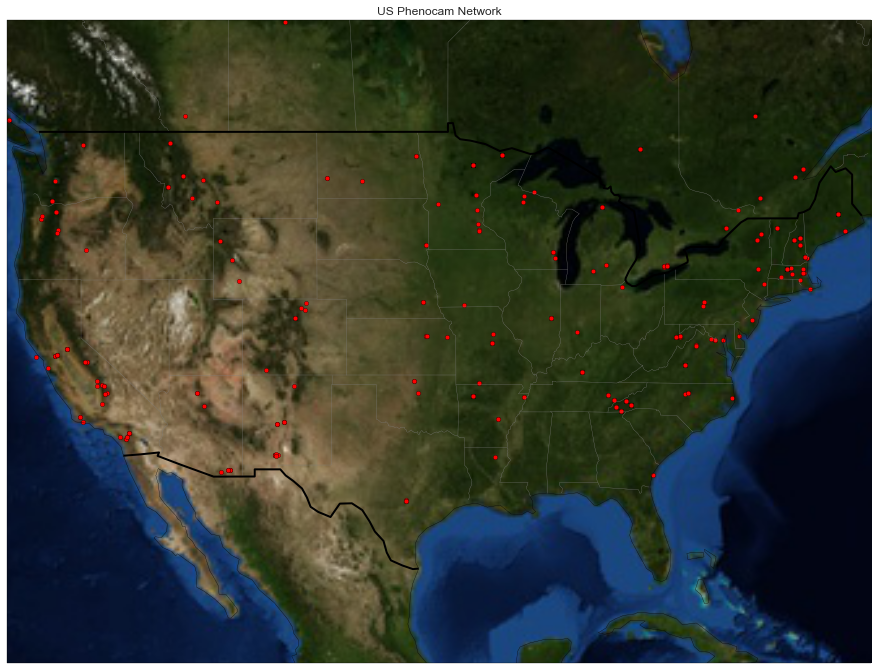

In [5]:
%matplotlib inline
fig = plt.figure(figsize=(12, 12))
ax_locatior = fig.add_axes(pyphenocam.plotting.LocatorMap(fig=fig))

### Or if you'd rather roll your own locator map

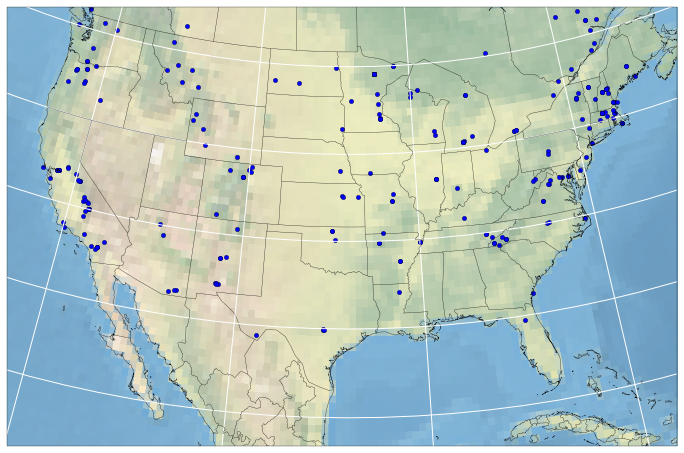

In [6]:
%matplotlib inline
import cartopy

import cartopy.feature as cfeature
import cartopy.crs as ccrs

# fig, ax = plt.subplots(figsize=(12,8))
# ax.scatter(sites.lon, sites.lat)

fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection=ccrs.LambertConformal())
ax.set_extent([-120, -73, 20, 50], ccrs.Geodetic())

ax.coastlines(resolution='10m')
ax.gridlines()
ax.stock_img()

states_provinces = cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale='10m',
            facecolor='none')


ax.add_feature(states_provinces, edgecolor='black', zorder=4)
ax.add_feature(cartopy.feature.BORDERS)

ax.scatter(sites.lon, sites.lat,  transform=ccrs.Geodetic())

## Get a single site

#### pyphenocam allows us to access the photos and precalulated metrics from any site with out pre-downloading any local data

Take a look at the available sites at: http://phenocam.sr.unh.edu/webcam/gallery/

In [7]:
aligatorriver = pyphenocam.dataaccess.get_site('alligatorriver')

### We can take a look at any photo from the site

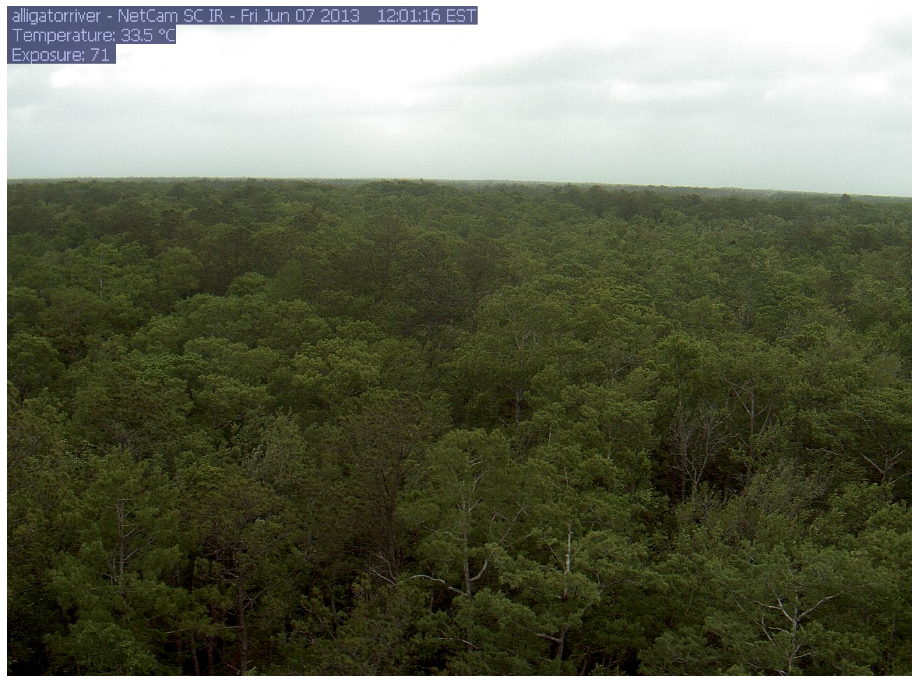

In [8]:
%matplotlib inline
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111)
date_of_interest = dt.datetime(2013, 6, 7)
ax.imshow(aligatorriver.get_midday_image(date_of_interest))

#this is a convience plotting function
pyphenocam.plotting.format_photo_axes(ax)

### Likewise we can take a look at the ROI for this photo

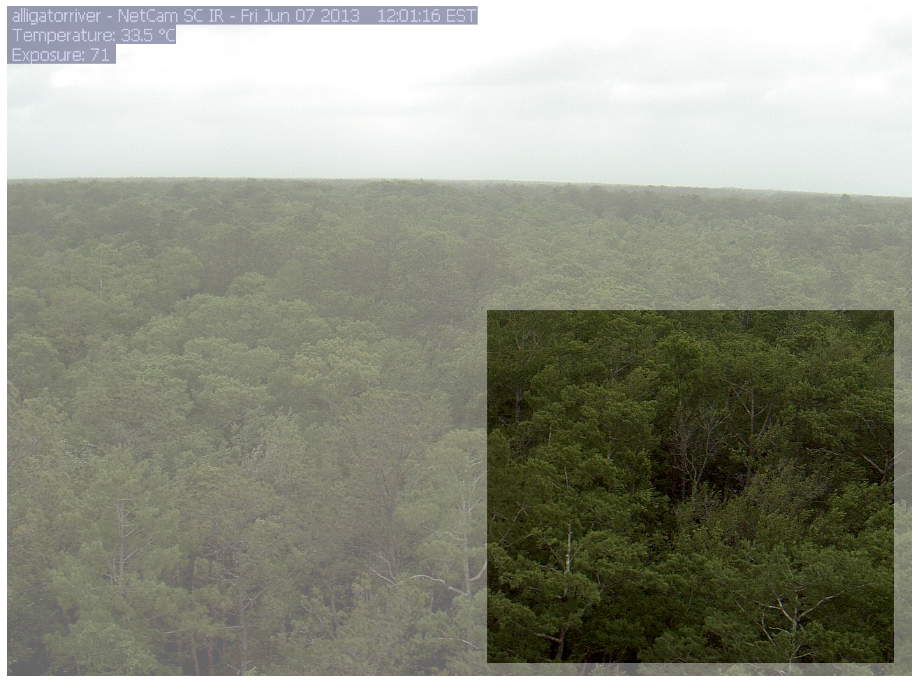

In [9]:
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111)
roi = aligatorriver.get_roi(masked=True)
ax.imshow(aligatorriver.get_midday_image(date_of_interest))
ax.imshow(roi, cmap=mpl.cm.Greys, alpha=0.4, vmax=1)
pyphenocam.plotting.format_photo_axes(ax)

#### If the site has more than one roi (veg type) we can add each separately, 
and even display them as an outline

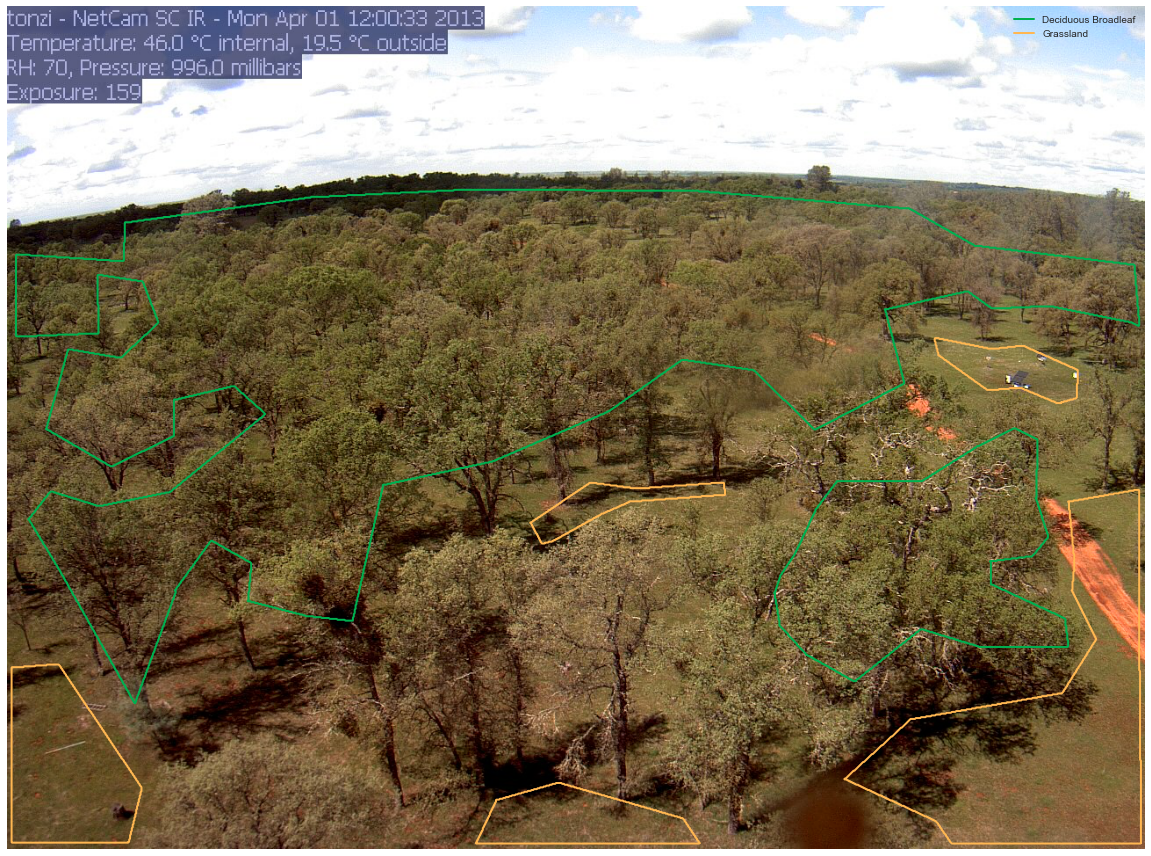

In [10]:
%matplotlib inline
tonzi = pyphenocam.dataaccess.get_site('tonzi')

fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111)


date_of_interest = dt.datetime(2013, 4, 1)
ax.imshow(tonzi.get_midday_image(date_of_interest))

pyphenocam.plotting.add_rois(ax, tonzi, vistype='line')

pyphenocam.plotting.format_photo_axes(ax)
fig.tight_layout()
plt.legend()

## In addition to the photo data we can view the precalculated ROI GCC and NDVI data

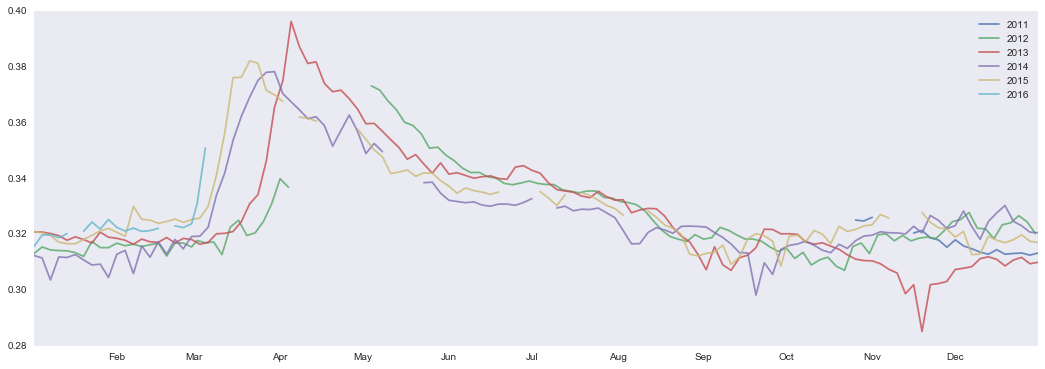

In [11]:
sns.set_style('dark')
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(111)
df = tonzi.get_data(length='3day')
for year in range(df.index.min().year, df.index.max().year+1):
    gcc = df.ix['{}-01-01'.format(year):'{}-12-31'.format(year)].gcc_90
    dateindex = [dt.datetime(2015, t.month, t.day) for t in gcc.index]
    gccvalues = gcc.values
    ax.plot(dateindex, gccvalues, label=year, alpha=0.8)
plt.legend()

import matplotlib.dates as mdates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

## These basic functions can be combined to create complex visualizations that integrate with  other data

In this case we've put Daymet temperature and precipitation data behind our chart.

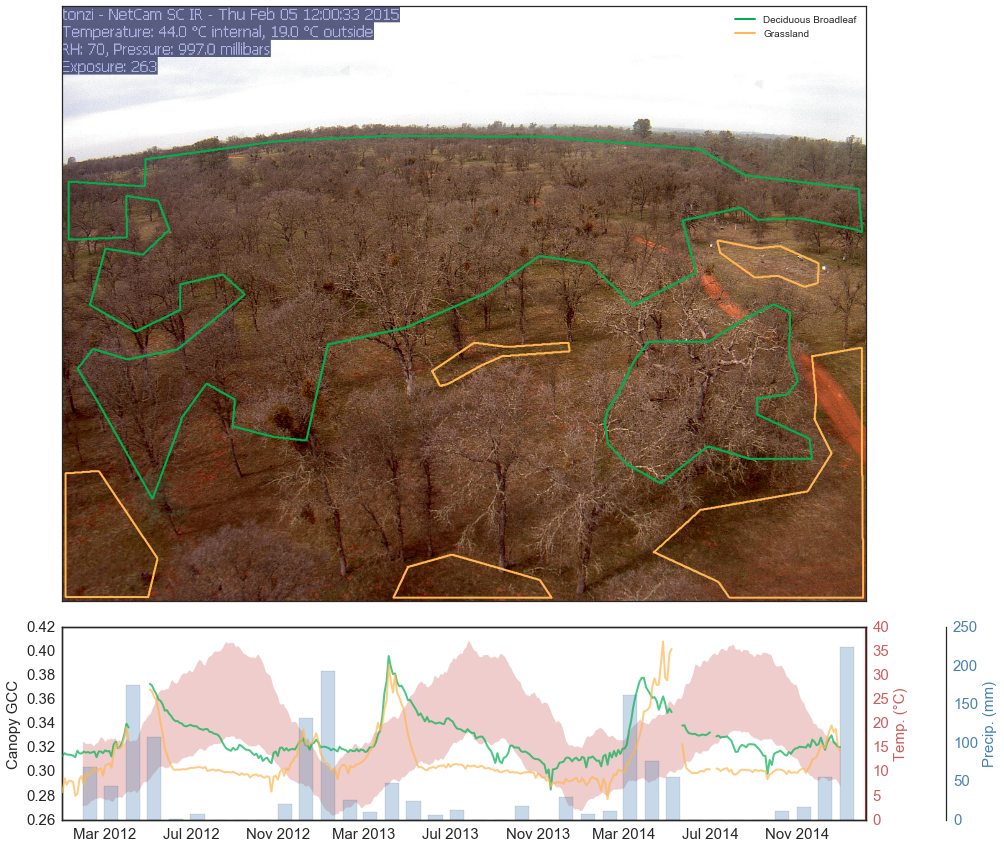

In [25]:
%matplotlib inline
sns.set_style('white') 

from IPython.html.widgets import *

def plot_one(which):
    fig = plt.figure(figsize=(14, 12))

    ax1 = plt.subplot2grid((4, 4), (3, 0), colspan=4)
    pyphenocam.plotting.plot_gcc_and_daymet(tonzi, ax1, start_year=2012, end_year=2014, fontsize=15, lw=2)

    forest_color = 'green'
    grass_color = 'sienna'
    ax2 = plt.subplot2grid((4, 4), (0, 0), rowspan=3, colspan=4)

    date_of_interest = pyphenocam.utils.parse_fname(tonzi.midday_fnames[which])[2]
    ax2.imshow(tonzi.get_midday_image(which))
    pyphenocam.plotting.add_rois(ax2, tonzi, vistype='line')

    conv = np.vectorize(mdates.strpdate2num('%Y-%m-%d'))
    ax1.axvline(conv("{}-{}-{}".format(date_of_interest.year, date_of_interest.month, date_of_interest.day)), color='r', zorder=0)

    pyphenocam.plotting.photo_format([ax2])

    plt.tight_layout()
    plt.legend()
               
interact(plot_one, which =(0, len(tonzi.midday_fnames)-1, 1))

In [23]:
pyphenocam.utils.parse_fname(tonzi.midday_fnames[0])


(False, 'tonzi', datetime.datetime(2011, 10, 27, 12, 1, 46))